In [128]:
import torch
import torch_geometric
import os
from glob import glob
import json
from torch_geometric.nn import radius, knn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from torch_geometric.nn.pool import knn
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_undirected, subgraph
import random
from torch_geometric.data import Batch
from copy import deepcopy
from torch_geometric.nn.pool import knn_graph, radius_graph
import importlib
from importlib import reload
import math
import sys
import time
import networkx as nx
import torch.nn.functional as F
%matplotlib notebook
%matplotlib inline

In [129]:
script_path = "/xdisk/twheeler/jgaiser/ContrastVS/contrast_vs/src/"

if script_path not in sys.path:
    sys.path.append(script_path)
    
original_cwd = os.getcwd()
os.chdir(script_path)

import utils
importlib.reload(utils)

import pdb_utils 
importlib.reload(pdb_utils)

import app_utils 
importlib.reload(app_utils)

from pdb_utils import vox_onehot
from app_utils import load_models

os.chdir(original_cwd)

In [130]:
# ---- Get union of 50 closest protein atoms per ligand atom
# ---- Store results for convenience

def trim_protein_graph(pg, mg, n_closest=50):
    '''
    Trims protein graph nodes so that only the n_closest to any mol atom is saved.
    For saving space and time.
    '''
    prox_prot_atoms = torch.unique(knn(pg.pos, mg.pos, n_closest)[1])

    pg.x = pg.x[prox_prot_atoms]
    pg.pos = pg.pos[prox_prot_atoms]
    
    return pg

def get_trimmed_pairs(pg_dir, mg_dir, n_closest=50):
    '''
    Get the trimmed protein and ligand graph pairs for every pdbbind sample.
    
    '''
    protein_graph_files = glob(pg_dir + '/*.pyg')
    mol_graph_files = glob(mg_dir + '/*.pyg')
    pairs = []

    for pg_i, pg_file in enumerate(protein_graph_files):
        pdb_id = pg_file.split('/')[-1].split('_')[0]
        no_mg = True 

        for mg_file in mol_graph_files:
            if pdb_id in mg_file:
                no_mg = False
                break

        if no_mg: continue

        pg = torch.load(pg_file)
        mg = torch.load(mg_file)

        trimmed_pg = trim_protein_graph(pg, mg, n_closest)
        pairs.append((trimmed_pg,mg))

    return pairs 

In [132]:
# protein_graph_dir = '/xdisk/twheeler/jgaiser/ContrastVS/data/pdbbind/protein_graphs/'
# mol_graph_dir = '/xdisk/twheeler/jgaiser/ContrastVS/data/pdbbind/k3_ligand_graphs/'

# PAIRS = get_trimmed_pairs(protein_graph_dir, mol_graph_dir)
    
# random.shuffle(PAIRS)
# torch.save(PAIRS[800:], '/xdisk/twheeler/jgaiser/ContrastVS/data/TRAIN_PAIRS_4-26.pt')
# torch.save(PAIRS[:800], '/xdisk/twheeler/jgaiser/ContrastVS/data/VALIDATION_PAIRS_4-26.pt')

TRAIN_PAIRS = torch.load('/xdisk/twheeler/jgaiser/ContrastVS/data/TRAIN_PAIRS_4-26.pt')
VALIDATION_PAIRS = torch.load('/xdisk/twheeler/jgaiser/ContrastVS/data/VALIDATION_PAIRS_4-26.pt')

In [133]:
def get_proximal_mol_atoms(pg, mg, max_dist=4):
    return torch.unique(radius(pg.pos, mg.pos, max_dist)[0])

def add_voxels(pg, vox_coords):
    pg = deepcopy(pg)
    vox_block = vox_onehot().unsqueeze(0).repeat(vox_coords.size(0),1)
    
    pg.vox_mask = torch.hstack((torch.zeros(pg.pos.size(0)),
                                torch.ones(vox_block.size(0)))).bool()
    
    pg.x = torch.vstack((pg.x, vox_block))
    pg.pos = torch.vstack((pg.pos, vox_coords))
    
    return pg
    
    
def generate_batch(pairs, 
                   vox_temp=0.5, 
                   protein_temp=0.1):
    p_batch = []
    m_batch = []
    
    for pg, mg in pairs:
        mg = deepcopy(mg)
        pg = deepcopy(pg)
         
        mg.prox_mask = torch.zeros(mg.x.size(0)).bool()
        mg.prox_mask[get_proximal_mol_atoms(pg, mg, 4)] = True
        
        vox_pos = mg.pos[mg.prox_mask]  
        
        vox_pos += torch.randn_like(vox_pos)*vox_temp
        pg.pos += torch.randn_like(pg.pos)*protein_temp
        
        pg = add_voxels(pg, vox_pos)
        
        p_batch.append(pg)
        m_batch.append(mg)
        
    return Batch.from_data_list(p_batch), Batch.from_data_list(m_batch)

In [134]:
def scramble_mol_indices(mb):
    scrambled_idx = []
    
    for i in torch.unique(mb.batch):
        neg_atom_pool = torch.where(mb.batch==i)[0]
        scrambled_idx.append(neg_atom_pool[torch.randperm(neg_atom_pool.size(0))])
        
    return(torch.hstack(scrambled_idx))

In [215]:
model_id = '5-9'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = '/xdisk/twheeler/jgaiser/ContrastVS/contrast_vs/models/%s/' % model_id

pe_w_path = model_path + 'pe_w_weighted.pt'
me_w_path = model_path + 'me_w_weighted.pt'

# pe, me = load_models(model_path, load_weights=True, weight_suffix='_weighted')
# pe, me = load_models(model_path, load_weights=True)
pe, me = load_models(model_path, load_weights=False)

pe = pe.to(device)
me = me.to(device)

In [144]:
def plot_histogram_data(data, bins=20):
    plt.clf()
    r = [x.item() for x in [data.mean()-data.std()*3, data.mean()+data.std()*3]]
    plt.hist(data, bins=bins, range=r, alpha=0.5)
    plt.ylim(top=500)
    plt.show()

0.4966216216216216


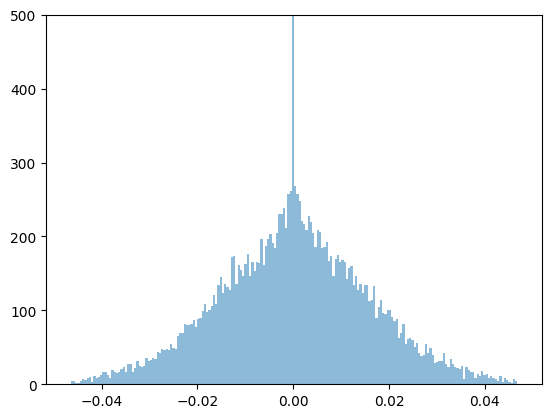

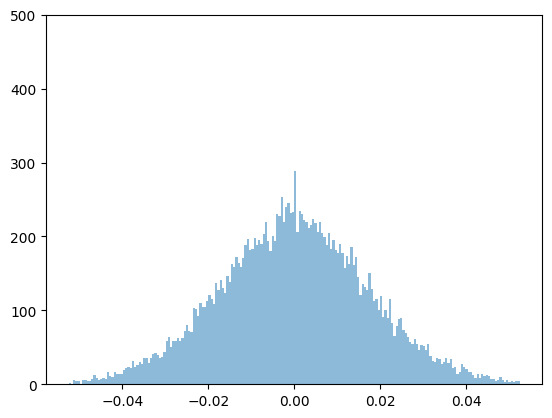

In [216]:
BATCH_SIZE = 16 

def cos_score(a, p, n):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    return cos(a,p)-cos(a,n)

def l2_score(a, p, n):
    return torch.norm(a-n, dim=1)-torch.norm(a-p, dim=1)

def combined_score(a,p,n):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    
    p_cos_d = 1-cos(a,p)
    n_cos_d = 1-cos(a,n)
    
    p_dist = torch.norm(a-p, dim=1)
    n_dist = torch.norm(a-n, dim=1)
    
    return n_cos_d*n_dist - p_cos_d*p_dist

def assess_scores(scores):
    return torch.where(scores > 0)[0].size(0) / scores.size(0)

def validate(pe, me, validation_pairs, score_function): 
    scores = [[], []]
    with torch.no_grad():
        pe.eval()
        me.eval()
        for bi in range(len(validation_pairs) // BATCH_SIZE):
            start_idx = bi*BATCH_SIZE
            stop_idx = start_idx + BATCH_SIZE
            pb,mb = generate_batch(validation_pairs[start_idx:stop_idx], vox_temp=0, protein_temp=0)

            voxel_embeds = pe(pb.to(device))
            mol_embeds = me(mb.to(device))

            mol_positives = mol_embeds[mb.prox_mask]
            mol_negatives = mol_embeds[scramble_mol_indices(mb)][mb.prox_mask]

            scores[0].append(score_function(voxel_embeds, 
                                            mol_positives, 
                                            mol_negatives))
            
            mol_negatives = mol_positives[torch.randperm(mol_positives.size(0))]
            
            scores[1].append(score_function(voxel_embeds, 
                                            mol_positives, 
                                            mol_negatives))
        
    pe.train()
    me.train()
    
    return (torch.hstack(scores[0]).detach().cpu(),
            torch.hstack(scores[1]).detach().cpu())
    
scores1, scores2 = validate(pe,me, VALIDATION_PAIRS, cos_score)
print(assess_scores(scores2))

plot_histogram_data(scores1, bins=200)
plot_histogram_data(scores2, bins=200)

In [147]:
def cos_distance(a, b):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    return 1-cos(a,b)

def l2_distance(a,b):
    return torch.norm(a-b, dim=1)

# cos_loss = torch.nn.CosineEmbeddingLoss(margin=0.5, reduction='none')
# lvals = cos_loss(cos_loss_v_anchor, cos_loss_m_embeds, y.to(device))
# tl_vals = t_loss(voxel_embeds, mol_positives, mol_negatives)
 

def get_contrastive_loss_weights(a, b, loss_vals, y, distance_function):
    weights = torch.zeros_like(loss_vals)
    distances = distance_function(a,b)
    
    p_dists = distances[y==1]
    n_dists = distances[y==-1]
    
    if p_dists.size(0) > 0:
        weights[y==1] = (p_dists-p_dists.min()) / (p_dists.max()-p_dists.min())
        
    if n_dists.size(0) > 0:
        weights[y==-1] = -(n_dists-n_dists.max()) / (n_dists.max()-n_dists.min())
    
    weights += 10
#     return torch.ones(weights.size(0)).to(device)
    return weights / weights.max()

    
# get_contrastive_loss_weights(cos_loss_v_anchor, cos_loss_m_embeds, lvals, y, cos_sim)
# tl_vals * get_contrastive_loss_weights(voxel_embeds, mol_negatives, tl_vals, -torch.ones(mol_positives.size(0)), l2_distance)


In [ ]:
torch.randn_like(torch.arange(10))

In [214]:
def euclidean_loss(a,p,n,margin=5):
    p_d = torch.norm(a-p, dim=0)
    n_d = torch.clamp(torch.norm(a-n, dim=0), max=margin)
    return p_d - n_d + margin

def nudge_loss(a,p,n,step=0.15,margin=2):
    a_target = a + (p-a)*step
    p_target = p + (a-p)*step
    
    a_repulse = a + (n-a)*(margin / torch.norm(p-n))
    p_repulse = p + (n-p)*(margin / torch.norm(p-n))
    
    a_attractor = a + a_target - a_repulse
    p_attractor = p + p_target - p_repulse
    
    return torch.norm(a-a_attractor, dim=0).mean() + torch.norm(p-p_attractor, dim=0).mean()
    
nudge_loss(voxel_embeds, mol_positives,mol_negatives)

tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
optimizer = torch.optim.AdamW(list(pe.parameters()) + 
                              list(me.parameters()), lr=5e-4)

t_loss = torch.nn.TripletMarginLoss(margin=1, p=2, eps=1e-7, reduction='none')
mse_loss = torch.nn.MSELoss()
cos_loss = torch.nn.CosineEmbeddingLoss(margin=0.5, reduction='none')

def normalize(embeds):
    return embeds / torch.norm(embeds, p=2, dim=1).unsqueeze(1)

def l2_reg(t):
    return mse_loss(t, normalize(t))

def noise_embeds(embeds, std=0.05):
    noise_tensor = torch.randn_like(embeds) 
    noisy_embeds = embeds + noise_tensor
    return noisy_embeds

pe.train()
me.train()

best_validation_score = assess_scores(validate(pe, me, VALIDATION_PAIRS, cos_score)[0])
print(best_validation_score)

for EPOCH in range(1000):
    l_hist = []
    
    for batch_idx in range(int(len(TRAIN_PAIRS) / BATCH_SIZE)):
        torch.cuda.empty_cache()

        optimizer.zero_grad()

        pb, mb = generate_batch(random.sample(TRAIN_PAIRS, BATCH_SIZE)) 
        
        voxel_embeds = pe(pb.to(device))
        mol_embeds = me(mb.to(device))
        
        mol_positives = mol_embeds[mb.prox_mask]
        mol_negatives = mol_embeds[scramble_mol_indices(mb)][mb.prox_mask]
        
        #--- cos loss
        cos_loss_v_anchor = voxel_embeds.repeat(3,1)
        cos_loss_m_embeds = torch.vstack((mol_positives,
                                          mol_negatives,
                                          mol_positives[torch.randperm(mol_positives.size(0))]))
        
        y = torch.ones(cos_loss_v_anchor.size(0))
        y[voxel_embeds.size(0):] = -1
        
        l0  = cos_loss(cos_loss_v_anchor, cos_loss_m_embeds, y.to(device))
        l0_w = get_contrastive_loss_weights(cos_loss_v_anchor, 
                                            cos_loss_m_embeds, 
                                            l0, y, cos_distance)
        
        #--- triplet loss
        l1 = t_loss(voxel_embeds, mol_positives, mol_negatives)
        l1_w = get_contrastive_loss_weights(voxel_embeds, 
                                            mol_negatives, 
                                            l1, -torch.ones(voxel_embeds.size(0)), l2_distance)
        
        shuffled_positives = mol_positives[torch.randperm(mol_positives.size(0))]
        l2 = t_loss(voxel_embeds, mol_positives, shuffled_positives)
        l2_w = get_contrastive_loss_weights(voxel_embeds, 
                                            shuffled_positives, 
                                            l2, -torch.ones(voxel_embeds.size(0)), l2_distance)
        
        shuffled_voxels = voxel_embeds[torch.randperm(voxel_embeds.size(0))]
        l3 = t_loss(mol_positives, voxel_embeds, shuffled_voxels)
        l3_w = get_contrastive_loss_weights(voxel_embeds, 
                                            shuffled_voxels, 
                                            l3, -torch.ones(voxel_embeds.size(0)), l2_distance)
        #----
#         weighted_l0 = (l0*l0_w).mean()
        weighted_l1 = (l1*l1_w).mean()
        weighted_l2 = (l2*l2_w).mean()
        weighted_l3 = (l3*l3_w).mean()
        
#         weighted_l0 = euclidean_loss(voxel_embeds, mol_positives, mol_negatives).mean() + euclidean_loss(voxel_embeds, mol_positives, shuffled_positives).mean() 
        weighted_l0 = nudge_loss(voxel_embeds, mol_positives, mol_negatives).mean()*10 
        
        
#         l = lc1*weighted_l0 + lc2*(weighted_l1 + weighted_l2) + lc3*weighted_l3 
#         l = weighted_l0 + 0.5*(weighted_l1 + weighted_l2) + weighted_l3 
#         l = l0
        l = weighted_l0
        l_hist.append((weighted_l0.item(), weighted_l1.item(), weighted_l2.item(), weighted_l3.item())) 
        
        l.backward()
        optimizer.step()
        
        if batch_idx % 50 == 0:
            loss_string = ""
            
            for l_i in range(len(l_hist[0])):
                loss_string += "%0.3f " % (sum([x[l_i] for x in l_hist])/len(l_hist))
                
            print(EPOCH, batch_idx, loss_string)
            
            l_hist = []
            
    v_score = assess_scores(validate(pe, me, VALIDATION_PAIRS, cos_score)[0])
    print(v_score)

    if v_score > best_validation_score:
        best_validation_score = v_score
        torch.save(pe.state_dict(), pe_w_path)
        torch.save(me.state_dict(), me_w_path)

    pe.train()
    me.train()

0.4831081081081081
0 0 13.099 0.956 0.951 0.951 
0 50 4.563 0.969 0.967 0.962 
0 100 2.823 0.985 0.984 0.969 
0 150 1.488 0.985 0.985 0.972 
0 200 1.096 0.979 0.981 0.972 
0 250 0.892 0.981 0.978 0.974 
0 300 0.767 0.978 0.977 0.974 
0 350 0.715 0.979 0.976 0.975 
0 400 0.694 0.978 0.978 0.978 
0 450 0.655 0.979 0.979 0.979 
0 500 0.580 0.980 0.979 0.983 
0 550 0.513 0.979 0.977 0.984 
0 600 0.509 0.978 0.978 0.987 
0 650 0.510 0.976 0.977 0.989 
0 700 0.510 0.978 0.978 0.987 
0 750 0.507 0.980 0.979 0.990 
0 800 0.507 0.980 0.979 0.991 
0 850 0.507 0.979 0.979 0.992 
0 900 0.506 0.981 0.980 0.991 
0 950 0.505 0.983 0.981 0.991 
0 1000 0.505 0.983 0.981 0.993 
0 1050 0.504 0.984 0.981 0.992 
0 1100 0.505 0.984 0.982 0.993 
